## 1. Imports and Configuration

In this section, we import the necessary libraries for Deep Learning, Computer Vision, and Data Visualization.

Run the cell below to verify your device (GPU/CPU) and set up global constants.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = 'split_dataset'
BATCH_SIZE = 512

print(f"Using device: {DEVICE}")

Using device: cuda


## 2. Load Model and Class Names

We are using `ResNet-50`, a deep Convolutional Neural Network (CNN) known for its high performance in image classification.

 - Transfer Learning: We load the `ResNet-50` architecture.
 - Custom Head: We replace the final fully connected layer (`fc`) to output predictions for our specific skin disease classes instead of the original 1000 `ImageNet` classes.
 - Weights: We load the state dictionary (`skin_disease_resnet.pth`) which contains the patterns the model learned during training.

This cell identifies your classes and loads the trained ResNet-50 weights. Ensure `skin_disease_resnet.pth` is in the same directory.

In [2]:
# 1. Identify Class Names
test_dir = os.path.join(DATA_DIR, 'test')
class_names = sorted(os.listdir(test_dir)) 
num_classes = len(class_names)
print(f"Classes found: {"\n * ".join([""] + class_names)}")

# 2. Load the Model Architecture
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# 3. Load Trained Weights
try:
    model.load_state_dict(torch.load('skin_disease_resnet.pth', map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()
    print("Model loaded successfully.")
except FileNotFoundError:
    print("Error: 'skin_disease_resnet.pth' not found. Make sure you have trained the model first.")

Classes found: 
 * atopic_dermatitis
 * basal_cell_carcinoma
 * benign_keratosis_like_lesions
 * eczema
 * melanocytic_nevi
 * melanoma
 * psoriasis_pictures_lichen_planus_related_diseases
 * seborrheic_keratoses_other_benign_tumors
 * tinea_ringworm_candidiasis_other_fungal_infections
 * warts_molluscum_other_viral_infections
Model loaded successfully.


## 3. Quantitative Evaluation

We evaluate the model on the Test Set to ensure it generalizes well to new, unseen images.

 - **Precision**: High precision means low false positives (important to avoid unnecessary anxiety).
 - **Recall**: High recall means low false negatives (critical to ensure dangerous conditions like Melanoma aren't missed).
 - **Confusion Matrix**: This heatmap helps us identify which specific diseases look similar to the model.

Evaluating on 2723 images from: split_dataset/test...

Overall Test Accuracy: 74.92%

----------------------------- Detailed Classification Report ------------------------------
                                                    precision    recall  f1-score   support

                                 atopic_dermatitis       0.54      0.46      0.49       127
                              basal_cell_carcinoma       0.83      0.85      0.84       333
                     benign_keratosis_like_lesions       0.69      0.63      0.66       209
                                            eczema       0.52      0.53      0.53       169
                                  melanocytic_nevi       0.91      0.94      0.92       797
                                          melanoma       0.94      0.90      0.92       314
 psoriasis_pictures_lichen_planus_related_diseases       0.53      0.55      0.54       206
          seborrheic_keratoses_other_benign_tumors       0.61      0.66      0.64    

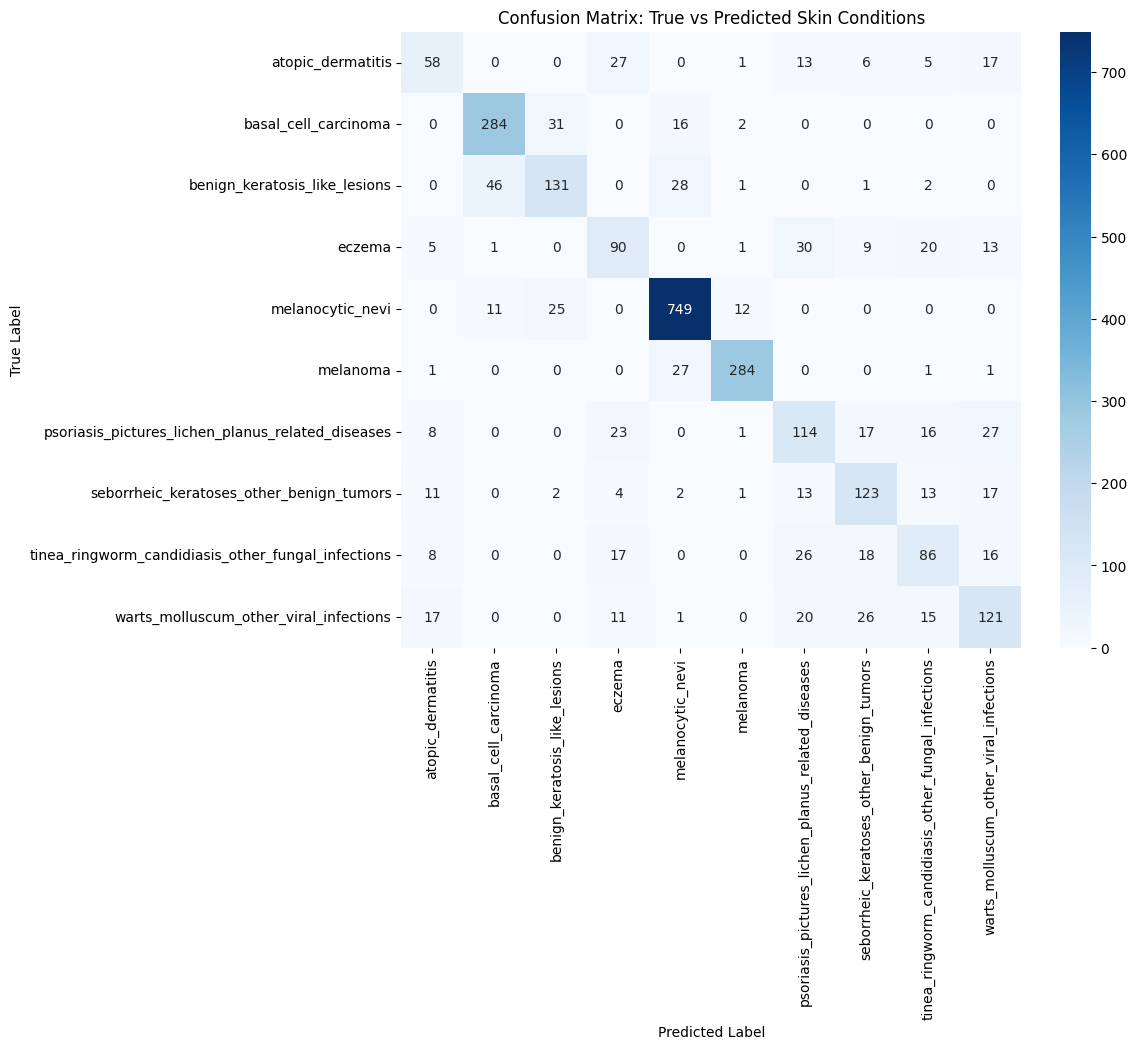

In [3]:
def evaluate_model(model: models.ResNet, data_dir: str, batch_size: int):
    """
    Runs inference on the test set and prints a comprehensive classification report
    and confusion matrix.
    """
    
    # 1. Setup Test Data Loading
    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    test_dir = os.path.join(data_dir, 'test')
    if not os.path.exists(test_dir):
        print(f"⚠️ Warning: '{test_dir}' not found. Using 'val' set for evaluation instead.")
        test_dir = os.path.join(data_dir, 'val')
        
    test_dataset = datasets.ImageFolder(test_dir, test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=5)
    class_names = test_dataset.classes

    print(f"Evaluating on {len(test_dataset)} images from: {test_dir}...")
    
    # 2. Generate Predictions
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    # 3. Calculate and Print Metrics
    overall_acc = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Test Accuracy: {overall_acc*100:.2f}%")
    
    print(f"\n{" Detailed Classification Report ":-^91}")
    # Generates precision, recall, f1-score for each class
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # 4. Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: True vs Predicted Skin Conditions')
    plt.show()

# Run the evaluation function
# Ensure 'model' is your trained model and 'DATA_DIR' is defined
evaluate_model(model, DATA_DIR, BATCH_SIZE)

## 4. GradCAM Visualization

Neural networks are often described as "black boxes." Grad-CAM (Gradient-weighted Class Activation Mapping) helps us peek inside by creating a "heatmap" of the image.

 - What it shows: The highlighted regions (usually in red/yellow) correspond to the areas of the skin lesion that the model focused on to make its prediction.
 - Why it matters: If the model predicts "Melanoma" but is looking at the dark corners of the image instead of the mole, we know the prediction might be unreliable.

Generating Explainable AI visualization for: ISIC_6674202.jpg...


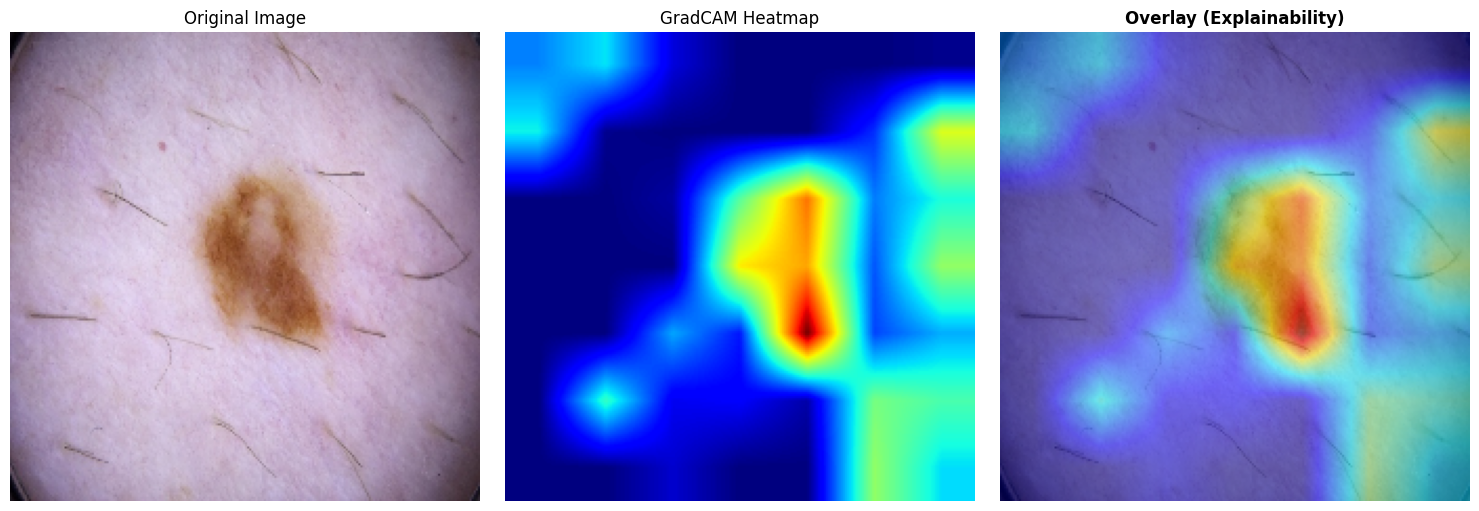

In [4]:
def visualize_gradcam(image_path: str, model: models.ResNet, target_layer: list[nn.modules.module.Module]):
    """
    Generates and displays the GradCAM heatmap for a specific image.
    """
    model.eval()
    
    # 1. Prepare the Image
    img = np.array(Image.open(image_path).convert('RGB'))
    img = cv2.resize(img, (224, 224))
    img_float = np.float32(img) / 255.0 # Normalize to 0-1 for visualization
    
    # Preprocess for the model
    input_tensor = preprocess_image(
        img_float, 
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ).to(DEVICE)

    # 2. Initialize GradCAM
    cam = GradCAM(model=model, target_layers=target_layer)

    # 3. Generate the CAM (Class Activation Map)
    # This generates the map for the highest scoring class automatically
    grayscale_cam = cam(input_tensor=input_tensor)
    
    # In this single image case, we take the first result
    grayscale_cam = grayscale_cam[0, :]

    # 4. Create the Visualization (Overlay heatmap on image)
    visualization = show_cam_on_image(img_float, grayscale_cam, use_rgb=True)

    # 5. Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img)
    axes[0].set_title("Original Image", fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(grayscale_cam, cmap='jet')
    axes[1].set_title("GradCAM Heatmap", fontsize=12)
    axes[1].axis('off')
    
    axes[2].imshow(visualization)
    axes[2].set_title("Overlay (Explainability)", fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- Run GradCAM ---
test_image_path = "split_dataset/test/melanoma/ISIC_6674202.jpg"
print(f"Generating Explainable AI visualization for: {os.path.basename(test_image_path)}...")

# Define the target layer (Last layer of the ResNet backbone)
target_layer = [model.layer4[-1]]

if os.path.exists(test_image_path):
    visualize_gradcam(test_image_path, model, target_layer)
else:
    print("Image not found. Run the prediction cell above to define the path.")

## Single Image Prediction Demo

This cell defines the prediction function and outputs the top 3 probabilities for a given image.

--- Analysis for t-eczema-subacute-7.jpg ---
Prediction: eczema
Confidence: 43.96%

Top 3 Probabilities:
eczema: 43.96%
psoriasis_pictures_lichen_planus_related_diseases: 19.54%
tinea_ringworm_candidiasis_other_fungal_infections: 17.19%


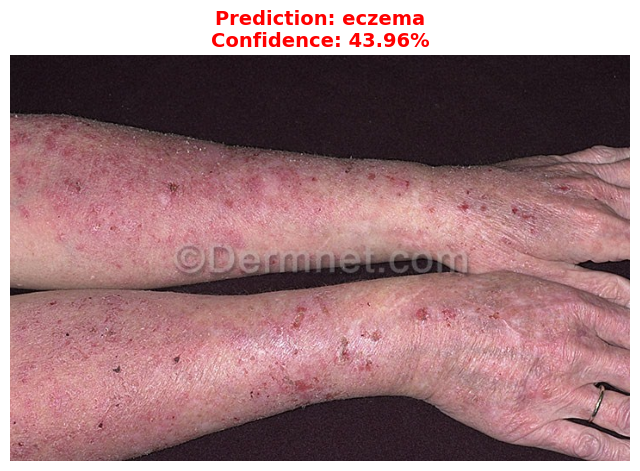

In [5]:
def predict_skin_disease(image_path: str, model: models.ResNet, class_names: list[str]):
    """
    Loads an image, runs inference, and displays the result with the image.
    """
    # 1. Load and Preprocess the Image
    # Define the standard transform used for ResNet inference
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Open image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(DEVICE) # Add batch dimension

    # 2. Run Inference
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1) # Convert logits to probabilities
        confidence, index = torch.max(probs, 1)

    pred_class = class_names[index.item()]
    conf_score = confidence.item() * 100

    # 3. Output Results (Terminal)
    print(f"--- Analysis for {os.path.basename(image_path)} ---")
    print(f"Prediction: {pred_class}")
    print(f"Confidence: {conf_score:.2f}%")
    
    print("\nTop 3 Probabilities:")
    top3_prob, top3_idx = torch.topk(probs, 3)
    for i in range(3):
        cls = class_names[top3_idx[0][i].item()]
        score = top3_prob[0][i].item() * 100
        print(f"{cls}: {score:.2f}%")

    # 4. Output Results (Visual)
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off') # Hide axes for a cleaner look
    
    # Color-code title: Green if high confidence, Red if low
    title_color = 'green' if conf_score > 75 else 'red'
    plt.title(f"Prediction: {pred_class}\nConfidence: {conf_score:.2f}%", 
              fontsize=14, color=title_color, fontweight='bold')
    plt.show()

    return pred_class, conf_score

# --- Run Prediction ---
test_image_path_2 = "split_dataset/test/eczema/t-eczema-subacute-7.jpg" 

if os.path.exists(test_image_path_2):
    predict_skin_disease(test_image_path_2, model, class_names)
else:
    print(f"Image not found at {test_image_path_2}. Please check the path.")